tensor([[-7.9885,  6.5468],
        [-4.6533, -5.9822],
        [-5.2046, -6.6521],
        [ 3.2618, -0.5764],
        [ 3.8611, -2.5363]]) tensor([3., 2., 2., 1., 1.])


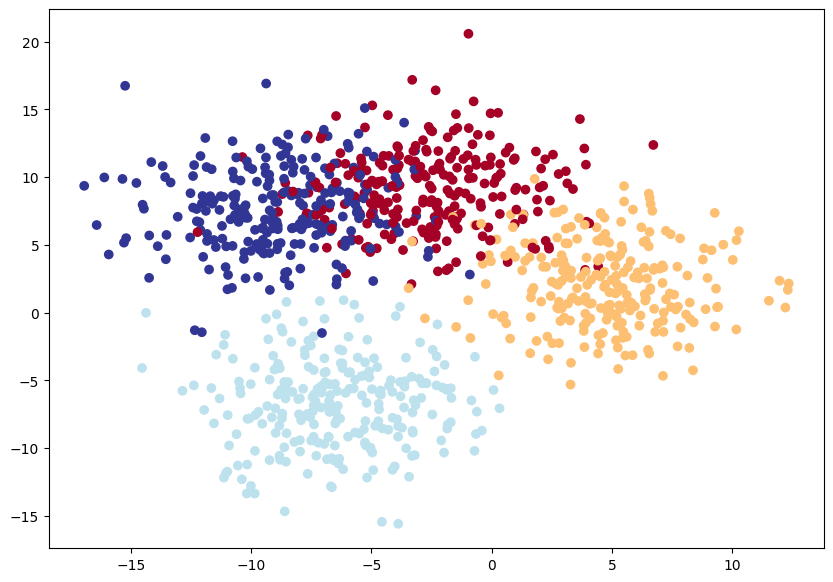

In [40]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=3,
    random_state=RANDOM_SEED
)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print(X_blob[:5], y_blob[:5])
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [42]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),

            nn.Linear(in_features=hidden_units, out_features=hidden_units),

            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [44]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.4557, -0.8263, -1.7031, -0.7176],
        [ 0.2167, -1.6137,  0.0271,  1.2023],
        [ 3.4144,  1.1932,  3.9576,  1.6247],
        [ 1.5900, -0.0103,  1.7726,  1.0840],
        [ 0.8662, -1.0021,  0.8314,  1.2568]], grad_fn=<SliceBackward0>)

In [45]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [46]:
y_logits = model_4(X_blob_test.to(device))

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.4233, -1.1498, -1.7140, -0.4481],
        [ 1.5376, -1.1611,  1.5487,  1.9092],
        [ 2.1548,  0.9075,  2.5277,  0.8407],
        [-0.5120, -0.2720, -0.5827, -0.3864],
        [-1.0917, -1.7494, -1.4350,  0.2665]], grad_fn=<SliceBackward0>)
tensor([[0.1750, 0.2301, 0.1309, 0.4641],
        [0.2834, 0.0191, 0.2866, 0.4110],
        [0.3325, 0.0955, 0.4827, 0.0893],
        [0.2306, 0.2931, 0.2149, 0.2614],
        [0.1635, 0.0847, 0.1160, 0.6358]], grad_fn=<SliceBackward0>)


In [47]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [48]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1750, 0.2301, 0.1309, 0.4641], grad_fn=<SelectBackward0>)
tensor(3)


In [49]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [50]:
torch.manual_seed(42)

epochs = 100
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

    model_4.train()


    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_4.eval()
    with torch.inference_mode():

      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

RuntimeError: expected scalar type Long but found Float

In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

In [ ]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")